In [1]:
!pip install braindecode

In [1]:
import os
import sys
import numpy as np

import torch  
import torch.nn as nn
import torch.optim as optim
import torchsummary
from torch.utils.data import Dataset, DataLoader, random_split
from braindecode.models import EEGConformer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
# plt.rcParams['font.family'] ='Times New Roman'

import seaborn as sns
import pywt
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from typing import Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2025-10-24 10:34:46.369456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 10:34:50.356956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 10:34:51.411543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 10:34:51.856601: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 10:34:54.915669: I tensorflow/core/platform/cpu_feature_guar

cuda


In [2]:
!apt-get install tree
!tree -L 1 /ocean/projects/cis250213p/shared

/bin/bash: apt-get: command not found
/ocean/projects/cis250213p/shared
├── img_speech
├── mi
├── p300
├── ssvep
└── unzip.ipynb

4 directories, 1 file


In [3]:
import itertools

def get_session_splits():
    all_sessions = [0, 1, 2, 3, 4, 5]
    session_splits = []

    for train_sessions in itertools.combinations(all_sessions, 4):
        remaining = [s for s in all_sessions if s not in train_sessions]
        val_session = remaining[0]
        test1_session = remaining[1]
        session_splits.append({
            'train': list(train_sessions),
            'val': val_session,
            'test1': test1_session
        })
    return session_splits

def load_data_by_session(root_dir, subject_id, session_idx_list):
    """Load one subject's data by session (following DualDiff framework)"""
    data = np.load(os.path.join(root_dir, f"S{subject_id}_chars.npy"))
    data = data[:, session_idx_list]  # [26, sessions, 64, 250]
    X = data.reshape(-1, 64, 250)    # [26*sessions, 64, 250]
    Y = np.repeat(np.arange(26), len(session_idx_list))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

def load_split_dataset(root_dir, num_seen, seed):
    """Load dataset with proper split (following DualDiff framework)"""
    random.seed(seed)
    all_subjects = list(range(1, 36))
    seen_subjects = random.sample(all_subjects, num_seen)
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]

    split_cfg = {
        "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
        "val":    [(sid, [4]) for sid in seen_subjects],
        "test1":  [(sid, [5]) for sid in seen_subjects],
        "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
    }

    print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

    datasets = {}
    
    for split, sid_sess in split_cfg.items():
        X_all, Y_all = [], []
        for sid, sess in sid_sess:
            X, Y = load_data_by_session(root_dir, sid, sess)
            X_all.append(X)
            Y_all.append(Y)

        X_all = torch.cat(X_all, dim=0)
        Y_all = torch.cat(Y_all, dim=0)
        datasets[split] = (X_all.numpy(), Y_all.numpy())

    return datasets

def zscore_norm(data):
    """Channel-wise z-score normalization (following DualDiff framework)"""
    # data: (C, T)
    mean = data.mean(dim=1, keepdim=True)  # shape: (C, 1)
    std = data.std(dim=1, keepdim=True)    # shape: (C, 1)
    return (data - mean) / (std + 1e-6)

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train the model with checkpoint saving and early stopping"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate, 
                           weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                     T_max=num_epochs / 2, 
                                                     eta_min=1e-6)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping parameters
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    
    print(f"Training on device: {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Early stopping patience: {patience}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping and checkpoint saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
            }, 'best_eeg_transformer_checkpoint.pth')
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        print(f'  Best Val Acc: {best_val_acc:.2f}%, Patience: {patience_counter}/{patience}')
        print('-' * 50)
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break
    
    # Load best model
    checkpoint = torch.load('best_eeg_transformer_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nTraining completed! Best model loaded.")
    print(f"Final best validation accuracy: {best_val_acc:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model on test set"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100. * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, all_predictions, all_targets

### SSVEP

In [6]:
import random

# Load dataset using DualDiff framework approach
subject_chars_dir = "/ocean/projects/cis250213p/shared/ssvep"

# Load data with proper split (following DualDiff)
datasets = load_split_dataset(subject_chars_dir, num_seen=33, seed=44)

# Extract datasets
X_train, y_train = datasets['train']
X_val, y_val = datasets['val'] 
X_test1, y_test1 = datasets['test1']
X_test2, y_test2 = datasets['test2']

print(f"Train data shape: {X_train.shape}, labels shape: {y_train.shape}")
print(f"Val data shape: {X_val.shape}, labels shape: {y_val.shape}")
print(f"Test1 data shape: {X_test1.shape}, labels shape: {y_test1.shape}")
print(f"Test2 data shape: {X_test2.shape}, labels shape: {y_test2.shape}")

# Create PyTorch datasets with normalization
class SSVEPDataset(Dataset):
    def __init__(self, data, labels, normalize=True):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
        self.normalize = normalize
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]  # [64, 250]
        y = self.labels[idx]
        
        if self.normalize:
            x = zscore_norm(x)  # Channel-wise normalization
            
        return x, y

# Create datasets
train_dataset = SSVEPDataset(X_train, y_train, normalize=True)
val_dataset = SSVEPDataset(X_val, y_val, normalize=True)
test1_dataset = SSVEPDataset(X_test1, y_test1, normalize=True)
test2_dataset = SSVEPDataset(X_test2, y_test2, normalize=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test1_loader = DataLoader(test1_dataset, batch_size=32, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=32, shuffle=False)

print(f"Data loaders created successfully!")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
print(f"Test1 batches: {len(test1_loader)}, Test2 batches: {len(test2_loader)}")

[Split] Seen subjects (train/val/test1): [27, 34, 8, 12, 13, 33, 10, 1, 30, 4, 19, 28, 26, 6, 17, 29, 31, 25, 11, 32, 2, 22, 5, 20, 3, 15, 9, 16, 18, 24, 21, 7, 14]
[Split] Unseen subjects (test2): [23, 35]
Train data shape: (3432, 64, 250), labels shape: (3432,)
Val data shape: (858, 64, 250), labels shape: (858,)
Test1 data shape: (858, 64, 250), labels shape: (858,)
Test2 data shape: (312, 64, 250), labels shape: (312,)
Data loaders created successfully!
Train batches: 108, Val batches: 27
Test1 batches: 27, Test2 batches: 10


In [4]:
# Create model
model = EEGConformer(
    n_chans=64,
    n_times=250, 
    n_outputs=26
)

model = nn.DataParallel(model, device_ids=[0,1,2,3]).to(device)

print(f"Model created successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

base = model.module

print(base.fc)

shapes = {}
def pre_fc_hook(m, inp):
    shapes['before_fc'] = inp[0].shape  # (B, ...)

h = base.fc.register_forward_pre_hook(pre_fc_hook)

probe_device = torch.device(f"cuda:{model.device_ids[0]}") if torch.cuda.is_available() else device
base = base.to(probe_device)
xb = next(iter(train_loader))[0].to(probe_device).float()

base.eval()
with torch.no_grad():
    try:
        _ = base(xb)
    except RuntimeError:
        pass
h.remove()
base.train()

K = int(np.prod(shapes['before_fc'][1:]))
print(f"Detected FC input dimension: {K}")

old_fc_seq = base.fc.fc
linears = [m for m in old_fc_seq if isinstance(m, nn.Linear)]
h1 = linears[0].out_features if len(linears) > 0 else 256
h2 = linears[1].out_features if len(linears) > 1 else 32

new_fc = nn.Sequential(
    nn.Linear(K, h1),
    nn.ELU(),
    nn.Dropout(p=0.5),
    nn.Linear(h1, h2),
    nn.ELU(),
    nn.Dropout(p=0.3),
)
base.fc.fc = new_fc
base = base.to(device)

Model created successfully!
Model parameters: 345,498
_FullyConnected(
  (fc): Sequential(
    (0): Linear(in_features=440, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
  )
)


NameError: name 'train_loader' is not defined


===== Training Model =====
Training on device: cuda
Number of parameters: 345,498
Early stopping patience: 10
New best model saved! Val Acc: 3.85%
Epoch 1/50:
  Train Loss: 3.3200, Train Acc: 3.55%
  Val Loss: 3.2910, Val Acc: 3.85%
  Learning Rate: 0.000996
  Best Val Acc: 3.85%, Patience: 0/10
--------------------------------------------------
Epoch 2/50:
  Train Loss: 3.3147, Train Acc: 3.44%
  Val Loss: 3.2613, Val Acc: 3.50%
  Learning Rate: 0.000984
  Best Val Acc: 3.85%, Patience: 1/10
--------------------------------------------------
New best model saved! Val Acc: 5.48%
Epoch 3/50:
  Train Loss: 3.2733, Train Acc: 4.98%
  Val Loss: 3.1704, Val Acc: 5.48%
  Learning Rate: 0.000965
  Best Val Acc: 5.48%, Patience: 0/10
--------------------------------------------------
New best model saved! Val Acc: 6.99%
Epoch 4/50:
  Train Loss: 3.1187, Train Acc: 6.79%
  Val Loss: 2.9040, Val Acc: 6.99%
  Learning Rate: 0.000938
  Best Val Acc: 6.99%, Patience: 0/10
-------------------------

Epoch 37/50:
  Train Loss: 1.6390, Train Acc: 33.80%
  Val Loss: 1.4817, Val Acc: 43.82%
  Learning Rate: 0.000469
  Best Val Acc: 49.30%, Patience: 7/10
--------------------------------------------------
Epoch 38/50:
  Train Loss: 1.6459, Train Acc: 32.55%
  Val Loss: 1.4062, Val Acc: 46.85%
  Learning Rate: 0.000532
  Best Val Acc: 49.30%, Patience: 8/10
--------------------------------------------------
Epoch 39/50:
  Train Loss: 1.6588, Train Acc: 33.51%
  Val Loss: 1.3994, Val Acc: 44.87%
  Learning Rate: 0.000594
  Best Val Acc: 49.30%, Patience: 9/10
--------------------------------------------------
Epoch 40/50:
  Train Loss: 1.6099, Train Acc: 34.73%
  Val Loss: 1.3803, Val Acc: 47.44%
  Learning Rate: 0.000655
  Best Val Acc: 49.30%, Patience: 10/10
--------------------------------------------------

Early stopping triggered! No improvement for 10 epochs.
Best validation accuracy: 49.30%

Training completed! Best model loaded.
Final best validation accuracy: 49.30%

===== Eva

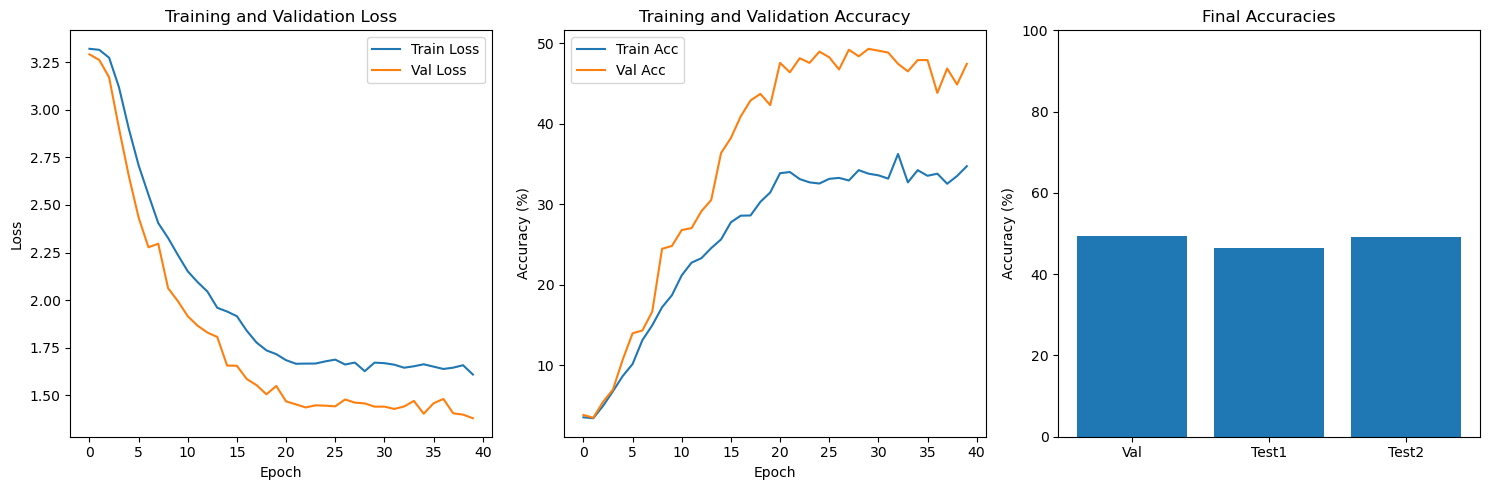


===== Training Complete =====
Best validation accuracy: 49.30%
Final test accuracies - Val: 49.30%, Test1: 46.39%, Test2: 49.04%


In [8]:
# Train model
print("\n===== Training Model =====")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=50, learning_rate=0.001
)

# Evaluate model
print("\n===== Evaluating Model =====")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100. * correct / total

acc_val = evaluate_model(model, val_loader)
acc_test1 = evaluate_model(model, test1_loader)
acc_test2 = evaluate_model(model, test2_loader)

print(f"Validation Accuracy: {acc_val:.2f}%")
print(f"Test1 Accuracy (seen subjects): {acc_test1:.2f}%")
print(f"Test2 Accuracy (unseen subjects): {acc_test2:.2f}%")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(['Val', 'Test1', 'Test2'], [acc_val, acc_test1, acc_test2])
plt.title('Final Accuracies')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n===== Training Complete =====")
print(f"Best validation accuracy: {max(val_accuracies):.2f}%")
print(f"Final test accuracies - Val: {acc_val:.2f}%, Test1: {acc_test1:.2f}%, Test2: {acc_test2:.2f}%")

### P300 / MI / Img. Speech

In [5]:
# Multi-task baseline evaluation for P300, MI, and Imagined Speech
import mne
import scipy.io
import random
import pandas as pd
from collections import defaultdict
import re
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Task configurations
TASKS = ["MI", "Imagined_speech", "P300"]
TASK_CONFIGS = {
    "P300": {
        "num_classes": 2,
        "channels": 32,
        "timepoints": 513,
        "num_subjects": 43,
        "num_seen": 36,
        "data_dir": "/ocean/projects/cis250213p/shared/p300",
        "label_dir": None
    },
    "MI": {
        "num_classes": 4,
        "channels": 22,
        "timepoints": 1001,
        "num_subjects": 9,
        "num_seen": 7,
        "data_dir": "/ocean/projects/cis250213p/shared/mi",
        "label_dir": None
    },
    "Imagined_speech": {
        "num_classes": 11,
        "channels": 62,
        "timepoints": 4900,
        "num_subjects": 14,
        "num_seen": 8,  # Reduced from 12 to be more realistic
        "data_dir": "/ocean/projects/cis250213p/shared/img_speech",
        "label_dir": None
    }
}

# Z-score normalization function
def zscore_norm(data):
    """Apply z-score normalization to EEG data"""
    # data: (C, T)
    mean = data.mean(dim=1, keepdim=True)  # shape: (C, 1)
    std = data.std(dim=1, keepdim=True)    # shape: (C, 1)
    return (data - mean) / (std + 1e-6)


In [6]:
# P300 data loading functions
def P300_split_repetitions(subject_data, min_reps=3):
    """Split P300 data by repetitions"""
    repetition_arr = np.array(subject_data["repetition"])
    
    train_idx, val_idx, test_idx = [], [], []
    
    for rep in range(max(repetition_arr) + 1):
        rep_indices = np.where(repetition_arr == rep)[0]
        if len(rep_indices) >= min_reps:
            # Split: 60% train, 20% val, 20% test
            n_train = int(len(rep_indices) * 0.6)
            n_val = int(len(rep_indices) * 0.2)
            
            train_idx.extend(rep_indices[:n_train])
            val_idx.extend(rep_indices[n_train:n_train + n_val])
            test_idx.extend(rep_indices[n_train + n_val:])
    
    return train_idx, val_idx, test_idx

def P300_load_subject_data(subject_id, root_dir):
    """Load P300 data for one subject"""
    folder = os.path.join(root_dir, f"subject_{subject_id:02d}")
    X = np.load(os.path.join(folder, "X.npy"))                # shape: (n_trials, C, T)
    Y = np.load(os.path.join(folder, "y.npy"))                # shape: (n_trials,)
    Y = np.array([1 if label == 'Target' else 0 for label in Y])

    meta = pd.read_csv(os.path.join(folder, "metadata.csv"))  # contains at least 'session'

    trials_per_repetition = 12
    reps_per_level = 8
    trials_per_level = reps_per_level * trials_per_repetition  # 96
    levels_per_session = 9

    level_list = []
    repetition_list = []

    for sess in sorted(meta["session"].unique()):
        session_idxs = meta.index[meta["session"] == sess].tolist()
        for i, idx in enumerate(session_idxs):
            rep = i // trials_per_repetition
            level = rep // reps_per_level
            repetition = rep % reps_per_level
            level_list.append(level)
            repetition_list.append(repetition)

    meta["level"] = level_list
    meta["repetition"] = repetition_list

    return {
        "X": X,
        "Y": Y,
        "session": meta["session"].tolist(),
        "level": meta["level"].tolist(),
        "repetition": meta["repetition"].tolist()
    }

def P300_load_split_dataset(root_dir, num_seen=36, seed=43, label_dir=None):
    """Load P300 dataset with proper split"""
    random.seed(seed)
    all_subjects = sorted([int(f.split('_')[1]) for f in os.listdir(root_dir)
                           if f.startswith('subject_') and os.path.isdir(os.path.join(root_dir, f))])
    all_subjects = [s for s in all_subjects if s not in [1, 27]]
    
    if num_seen >= len(all_subjects):
        print(f"Warning: Not enough subjects. Requested {num_seen}, available {len(all_subjects)}")
        num_seen = len(all_subjects) - 2  # Leave 2 for test2
        
    seen_subjects = random.sample(all_subjects, num_seen)
    unseen_subjects = [s for s in all_subjects if s not in seen_subjects]

    print(f"[P300 Split] Seen: {seen_subjects}")
    print(f"[P300 Split] Unseen: {unseen_subjects}")

    # Process seen subjects
    X_train_all, Y_train_all = [], []
    X_val_all, Y_val_all = [], []
    X_test1_all, Y_test1_all = [], []

    for sid in seen_subjects:
        try:
            data = P300_load_subject_data(sid, root_dir)
            X, Y = torch.tensor(data['X']).float(), torch.tensor(data['Y']).long()
            train_idx, val_idx, test1_idx = P300_split_repetitions(data)
            
            X_train_all.append(X[train_idx])
            Y_train_all.append(Y[train_idx])
            X_val_all.append(X[val_idx])
            Y_val_all.append(Y[val_idx])
            X_test1_all.append(X[test1_idx])
            Y_test1_all.append(Y[test1_idx])
        except Exception as e:
            print(f"Error loading subject {sid}: {e}")
            continue

    # Process unseen subjects for test2
    X_test2_all, Y_test2_all = [], []
    for sid in unseen_subjects:
        try:
            data = P300_load_subject_data(sid, root_dir)
            X, Y = torch.tensor(data['X']).float(), torch.tensor(data['Y']).long()
            X_test2_all.append(X)
            Y_test2_all.append(Y)
        except Exception as e:
            print(f"Error loading subject {sid}: {e}")
            continue

    # Create datasets
    datasets = {}
    if X_train_all:
        datasets['train'] = (torch.cat(X_train_all, dim=0).numpy(), torch.cat(Y_train_all, dim=0).numpy())
    if X_val_all:
        datasets['val'] = (torch.cat(X_val_all, dim=0).numpy(), torch.cat(Y_val_all, dim=0).numpy())
    if X_test1_all:
        datasets['test1'] = (torch.cat(X_test1_all, dim=0).numpy(), torch.cat(Y_test1_all, dim=0).numpy())
    if X_test2_all:
        datasets['test2'] = (torch.cat(X_test2_all, dim=0).numpy(), torch.cat(Y_test2_all, dim=0).numpy())

    return datasets


In [7]:
# MI data loading functions
def MI_load_data_by_session(root_dir, subject_id, session_folders, label_dir=None):
    """Load MI data by session (adapted for actual data structure)"""
    X_list, Y_list = [], []

    for folder in session_folders:
        # For MI data, files are directly in the mi folder, not in subfolders
        fname = f"A{subject_id:02d}T.fif"  # All MI files end with T
        fpath = os.path.join(root_dir, fname)
        
        if not os.path.exists(fpath):
            print(f"Warning: {fpath} not found, skipping subject {subject_id}")
            continue
            
        raw = mne.io.read_raw_fif(fpath, preload=True, verbose=False)

        # MI cue as '769'~'772'，mapping as 0–3 labels
        events, event_id = mne.events_from_annotations(raw, verbose=False)
        motor_keys = ['769', '770', '771', '772']
        motor_event_id = {k: v for k, v in event_id.items() if k in motor_keys}
        if len(motor_event_id) < 4:
            print(f"Warning: {fname} missing MI cues. Found: {event_id}")
            continue
            
        events = np.array([e for e in events if e[2] in motor_event_id.values()])
        label_map = {
            motor_event_id['769']: 0,
            motor_event_id['770']: 1,
            motor_event_id['771']: 2,
            motor_event_id['772']: 3,
        }
        labels = np.array([label_map[e[-1]] for e in events])

        epochs = mne.Epochs(
            raw, events,
            tmin=0.0,
            tmax=4.0,
            baseline=None,
            preload=True,
            verbose=False,
            event_repeated="drop"
        )
        data = epochs.get_data()
        X_list.append(torch.from_numpy(data).float())
        Y_list.append(torch.from_numpy(labels).long())

    if not X_list:
        return torch.empty(0, 0, 0), torch.empty(0, dtype=torch.long)
        
    X = torch.cat(X_list, dim=0)
    Y = torch.cat(Y_list, dim=0)
    return X, Y

def split_by_class_and_run(Y, seed=44, trials_per_run=12, n_classes=4, n_runs=6, train_count=8, val_count=2, test_count=2, num_sessions=1):
    """Split MI data by class and run (first session only)"""
    random.seed(seed)
    train_idx, val_idx, test_idx = [], [], []
    for cls in range(n_classes):
        cls_indices = (Y == cls).nonzero(as_tuple=True)[0]
        expected_count = trials_per_run * n_runs * num_sessions
        if len(cls_indices) != expected_count:
            print(f"Warning: Class {cls} expected {expected_count}, got {len(cls_indices)}")
            # Adjust expected count to actual count
            expected_count = len(cls_indices)
            trials_per_run = expected_count // n_runs

        for run in range(n_runs):
            start_idx = run * trials_per_run
            end_idx = (run + 1) * trials_per_run
            if end_idx > len(cls_indices):
                end_idx = len(cls_indices)
            if start_idx >= end_idx:
                break
                
            run_trials = cls_indices[start_idx:end_idx].tolist()
            random.shuffle(run_trials)
            
            # Adjust counts based on available trials
            actual_train = min(train_count, len(run_trials))
            actual_val = min(val_count, len(run_trials) - actual_train)
            actual_test = len(run_trials) - actual_train - actual_val
            
            train_idx.extend(run_trials[:actual_train])
            val_idx.extend(run_trials[actual_train:actual_train + actual_val])
            test_idx.extend(run_trials[actual_train + actual_val:])
            
    return train_idx, val_idx, test_idx

def MI_load_split_dataset(root_dir, num_seen=7, seed=43, label_dir=None):
    """Load MI dataset with proper split (adapted for actual data structure)"""
    random.seed(seed)
    all_subjects = list(range(1, 10))  # A01T.fif to A09T.fif
    seen_subjects = random.sample(all_subjects, num_seen)
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]

    print(f"[MI Split] Seen: {seen_subjects}")
    print(f"[MI Split] Unseen: {unseen_subjects}")

    # Load train_val data first (first session only)
    X_train_all, Y_train_all, train_subject_ids = [], [], []
    X_val_all, Y_val_all, val_subject_ids = [], [], []
    X_test1_all, Y_test1_all, test1_subject_ids = [], [], []

    for sid in seen_subjects:
        # Load data directly from mi folder
        X, Y = MI_load_data_by_session(root_dir, sid, ["first_session"], label_dir)
        
        if len(X) == 0:
            print(f"Skipping subject {sid} - no data loaded")
            continue
            
        train_idx, val_idx, test_idx = split_by_class_and_run(
            Y, seed=seed, num_sessions=1
        )

        X_train_all.append(X[train_idx])
        Y_train_all.append(Y[train_idx])
        train_subject_ids.extend([sid] * len(train_idx))

        X_val_all.append(X[val_idx])
        Y_val_all.append(Y[val_idx])
        val_subject_ids.extend([sid] * len(val_idx))

        X_test1_all.append(X[test_idx])
        Y_test1_all.append(Y[test_idx])
        test1_subject_ids.extend([sid] * len(test_idx))

    # Load test2 data (first session only)
    X_test2_all, Y_test2_all, test2_subject_ids = [], [], []

    for sid in unseen_subjects:
        X, Y = MI_load_data_by_session(root_dir, sid, ["first_session"], label_dir)
        if len(X) > 0:
            X_test2_all.append(X)
            Y_test2_all.append(Y)
            test2_subject_ids.extend([sid] * len(Y))

    # Create datasets
    datasets = {}
    if X_train_all:
        datasets['train'] = (torch.cat(X_train_all, dim=0).numpy(), torch.cat(Y_train_all, dim=0).numpy())
    if X_val_all:
        datasets['val'] = (torch.cat(X_val_all, dim=0).numpy(), torch.cat(Y_val_all, dim=0).numpy())
    if X_test1_all:
        datasets['test1'] = (torch.cat(X_test1_all, dim=0).numpy(), torch.cat(Y_test1_all, dim=0).numpy())
    if X_test2_all:
        datasets['test2'] = (torch.cat(X_test2_all, dim=0).numpy(), torch.cat(Y_test2_all, dim=0).numpy())

    return datasets


In [8]:
# Imagined Speech data loading functions
def ImaginedSpeech_split_repetitions(subject_data):
    """Split Imagined Speech data by repetitions"""
    repetition_arr = np.array(subject_data["repetition"])
    
    train_idx, val_idx, test_idx = [], [], []
    
    for rep in range(max(repetition_arr) + 1):
        rep_indices = np.where(repetition_arr == rep)[0]
        if len(rep_indices) > 0:
            # Split: 60% train, 20% val, 20% test
            n_train = int(len(rep_indices) * 0.6)
            n_val = int(len(rep_indices) * 0.2)
            
            train_idx.extend(rep_indices[:n_train])
            val_idx.extend(rep_indices[n_train:n_train + n_val])
            test_idx.extend(rep_indices[n_train + n_val:])
    
    return train_idx, val_idx, test_idx

# Fixed Imagined Speech data loading functions
from collections import defaultdict
def ImaginedSpeech_load_subject_data(subject_id, root_dir):
    """
    subject_id.npy  + subject_id_labels.npy  한 쌍을 로드합니다.
    예: MM05.npy, MM05_labels.npy
    """
    x_path = os.path.join(root_dir, f"{subject_id}.npy")
    y_path = os.path.join(root_dir, f"{subject_id}_labels.npy")

    if not os.path.exists(x_path):
        raise FileNotFoundError(f"Data file missing: {x_path}")
    if not os.path.exists(y_path):
        raise FileNotFoundError(f"Label file missing: {y_path}")

    X = np.load(x_path)                              # (n_trials, C, T)
    Y_raw = np.load(y_path, allow_pickle=True).ravel()  # (n_trials,)

    # 라벨 -> 정수 인덱스
    label_set = sorted(set(Y_raw.tolist()))
    label2idx = {lab: i for i, lab in enumerate(label_set)}
    Y = np.array([label2idx[lab] for lab in Y_raw])

    # "반복(repetition)" 인덱스: 같은 라벨이 몇 번째로 등장했는지 카운트
    cnt = defaultdict(int)
    repetition = []
    for lab in Y_raw:
        repetition.append(cnt[lab])
        cnt[lab] += 1

    return {"X": X, "Y": Y, "repetition": repetition, "label2idx": label2idx}
    
import random

def ImaginedSpeech_load_split_dataset(root_dir, num_seen=8, seed=43, label_dir=None):
    import os, random
    random.seed(seed)

    files = [f for f in os.listdir(root_dir) if f.endswith(".npy")]
    data_bases  = {os.path.splitext(f)[0] for f in files if not f.endswith("_labels.npy")}
    label_bases = {f[:-len("_labels.npy")] for f in files if f.endswith("_labels.npy")}  # ← 고친 부분
    all_subjects = sorted(data_bases & label_bases)  # 완전한 쌍만 사용

    print(f"Available subjects: {all_subjects}")
    n = len(all_subjects)
    print(f"Total subjects found: {n}")

    if n < 3:
        print(f"Error: Found only {n} subject(s). Need ≥ 3 (≥1 seen, ≥2 unseen).")
        return {}

    num_seen = int(num_seen)
    if num_seen < 1:
        num_seen = 1
    if num_seen > n - 2:
        print(f"Warning: Requested num_seen={num_seen} too large; capping to {n-2}")
        num_seen = n - 2

    seen_subjects = random.sample(all_subjects, num_seen)
    unseen_subjects = [s for s in all_subjects if s not in seen_subjects]

    print(f"[Imagined Speech Split] Seen:   {seen_subjects}")
    print(f"[Imagined Speech Split] Unseen: {unseen_subjects}")

    X_train_all, Y_train_all = [], []
    X_val_all,   Y_val_all   = [], []
    X_test1_all, Y_test1_all = [], []

    for sid in seen_subjects:
        try:
            data = ImaginedSpeech_load_subject_data(sid, root_dir)
            X = torch.tensor(data['X']).float()
            Y = torch.tensor(data['Y']).long()
            train_idx, val_idx, test1_idx = ImaginedSpeech_split_repetitions(data)
            X_train_all.append(X[train_idx]); Y_train_all.append(Y[train_idx])
            X_val_all.append(X[val_idx]);     Y_val_all.append(Y[val_idx])
            X_test1_all.append(X[test1_idx]); Y_test1_all.append(Y[test1_idx])
        except Exception as e:
            print(f"Error loading subject {sid}: {e}")

    X_test2_all, Y_test2_all = [], []
    for sid in unseen_subjects:
        try:
            data = ImaginedSpeech_load_subject_data(sid, root_dir)
            X = torch.tensor(data['X']).float()
            Y = torch.tensor(data['Y']).long()
            X_test2_all.append(X); Y_test2_all.append(Y)
        except Exception as e:
            print(f"Error loading subject {sid}: {e}")

    datasets = {}
    if X_train_all:
        datasets['train'] = (torch.cat(X_train_all, dim=0).numpy(),
                             torch.cat(Y_train_all, dim=0).numpy())
    if X_val_all:
        datasets['val']   = (torch.cat(X_val_all,   dim=0).numpy(),
                             torch.cat(Y_val_all,   dim=0).numpy())
    if X_test1_all:
        datasets['test1'] = (torch.cat(X_test1_all, dim=0).numpy(),
                             torch.cat(Y_test1_all, dim=0).numpy())
    if X_test2_all:
        datasets['test2'] = (torch.cat(X_test2_all, dim=0).numpy(),
                             torch.cat(Y_test2_all, dim=0).numpy())

    return datasets


In [9]:
# EEG Dataset class for multi-task evaluation (without STFT)
class EEGDataset(Dataset):
    def __init__(self, data, labels, normalize=True):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
        self.normalize = normalize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        
        if self.normalize:
            x = zscore_norm(x)
        
        return x, y

# Enhanced training function with RMSprop and CyclicLR
def train_model_enhanced(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, task_name="task"):
    """Enhanced training function with RMSprop and CyclicLR scheduler"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CyclicLR(
        optimizer=optimizer,
        base_lr=learning_rate * 0.1,
        max_lr=learning_rate,
        step_size_up=num_epochs // 4,
        mode="exp_range",
        cycle_momentum=False,
        gamma=0.9
    )
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping parameters
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    
    print(f"Training on device: {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Early stopping patience: {patience}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            
            optimizer.zero_grad(set_to_none=True)
            output = model(data)

            target = target.to(output.device, non_blocking=True)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                
                output = model(data)

                target = target.to(output.device, non_blocking=True)
                
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping and checkpoint saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
            }, f'best_model_checkpoint_{task_name}.pth')
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        print(f'  Best Val Acc: {best_val_acc:.2f}%, Patience: {patience_counter}/{patience}')
        print('-' * 50)
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break
    
    # Load best model
    try:
        checkpoint = torch.load(f'best_model_checkpoint_{task_name}.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\nTraining completed! Best model loaded.")
        print(f"Final best validation accuracy: {best_val_acc:.2f}%")
    except:
        print(f"\nTraining completed! No checkpoint found.")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
# Enhanced evaluation function
def evaluate_model_enhanced(model, test_loader, task_name="task"):
    """Enhanced evaluation function with detailed metrics"""
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_probabilities = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probabilities = torch.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100. * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    
    # F1 score
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    
    # AUC (for binary classification)
    try:
        if len(set(all_targets)) == 2:  # Binary classification
            auc = roc_auc_score(all_targets, all_probabilities[:, 1])
        else:  # Multi-class classification
            auc = roc_auc_score(all_targets, all_probabilities, multi_class='ovr', average='weighted')
    except:
        auc = 0.0
    
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {task_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{task_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'predictions': all_predictions,
        'targets': all_targets
    }


MULTI-TASK BASELINE EVALUATION WITH EEG TRANSFORMER

TASK: MI
Configuration: {'num_classes': 4, 'channels': 22, 'timepoints': 1001, 'num_subjects': 9, 'num_seen': 7, 'data_dir': '/ocean/projects/cis250213p/shared/mi', 'label_dir': None}
[MI Split] Seen: [1, 5, 6, 2, 4, 3, 8]
[MI Split] Unseen: [7, 9]
2D data: 22 channels, 1001 timepoints
Data shape: (22, 1001)
Number of classes: 4
Detected FC input dimension: 2440
Model created with 789,572 parameters

Training MI model...
Training on device: cuda
Number of parameters: 789,572
Early stopping patience: 10
New best model saved! Val Acc: 27.68%
Epoch 1/50:
  Train Loss: 1.4271, Train Acc: 25.89%
  Val Loss: 1.3825, Val Acc: 27.68%
  Learning Rate: 0.000168
  Best Val Acc: 27.68%, Patience: 0/10
--------------------------------------------------
New best model saved! Val Acc: 30.36%
Epoch 2/50:
  Train Loss: 1.4060, Train Acc: 27.60%
  Val Loss: 1.3590, Val Acc: 30.36%
  Learning Rate: 0.000221
  Best Val Acc: 30.36%, Patience: 0/10
------

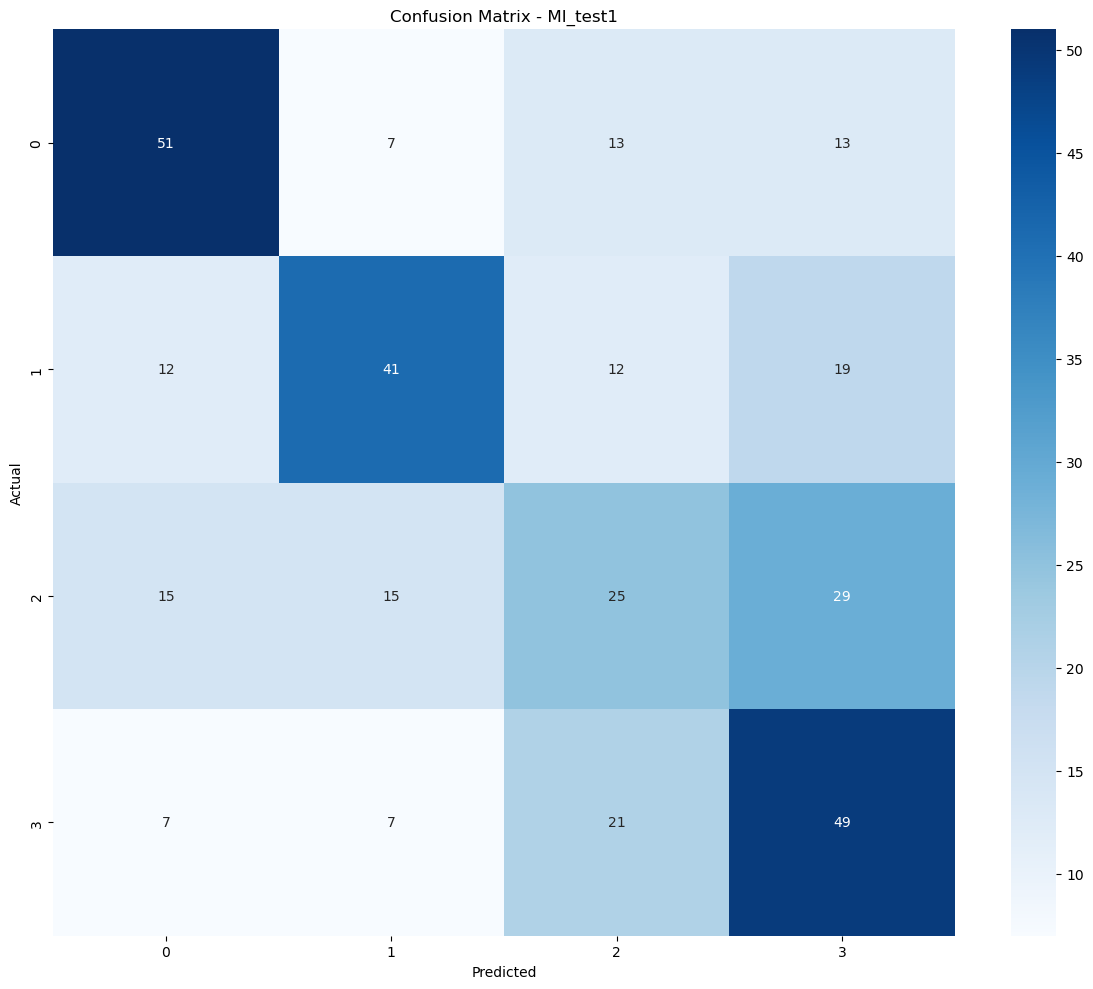


--- Test2 (Unseen subjects) ---
Test Accuracy: 43.23%
F1 Score: 0.4298
Precision: 0.4307
Recall: 0.4323
AUC: 0.6708

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       144
           1       0.49      0.42      0.45       144
           2       0.34      0.31      0.32       144
           3       0.43      0.44      0.43       144

    accuracy                           0.43       576
   macro avg       0.43      0.43      0.43       576
weighted avg       0.43      0.43      0.43       576



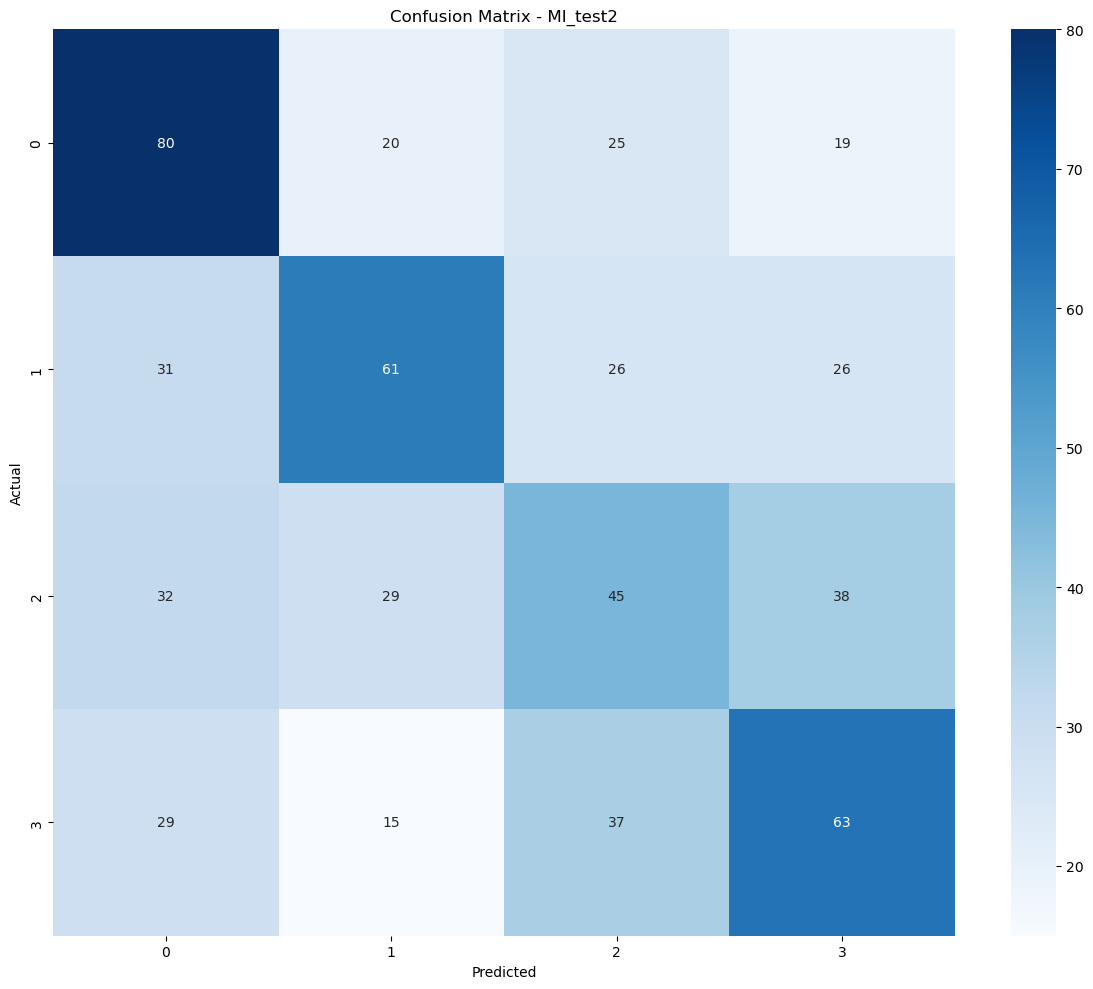


MI completed!
Best validation accuracy: 56.25%
Test1 accuracy: 49.40%
Test2 accuracy: 43.23%

TASK: P300
Configuration: {'num_classes': 2, 'channels': 32, 'timepoints': 513, 'num_subjects': 43, 'num_seen': 36, 'data_dir': '/ocean/projects/cis250213p/shared/p300', 'label_dir': None}
[P300 Split] Seen: [4, 20, 11, 32, 25, 8, 40, 34, 3, 30, 42, 13, 21, 36, 19, 26, 15, 14, 7, 35, 5, 22, 39, 6, 31, 24, 10, 28, 9, 43, 38, 41, 16, 29, 33, 23]
[P300 Split] Unseen: [2, 12, 17, 18, 37]
2D data: 32 channels, 513 timepoints
Data shape: (32, 513)
Number of classes: 2
Detected FC input dimension: 1120
Model created with 467,586 parameters

Training P300 model...
Training on device: cuda
Number of parameters: 467,586
Early stopping patience: 10
New best model saved! Val Acc: 85.26%
Epoch 1/50:
  Train Loss: 0.4004, Train Acc: 83.88%
  Val Loss: 0.3668, Val Acc: 85.26%
  Learning Rate: 0.000168
  Best Val Acc: 85.26%, Patience: 0/10
--------------------------------------------------
Epoch 2/50:
  Tra

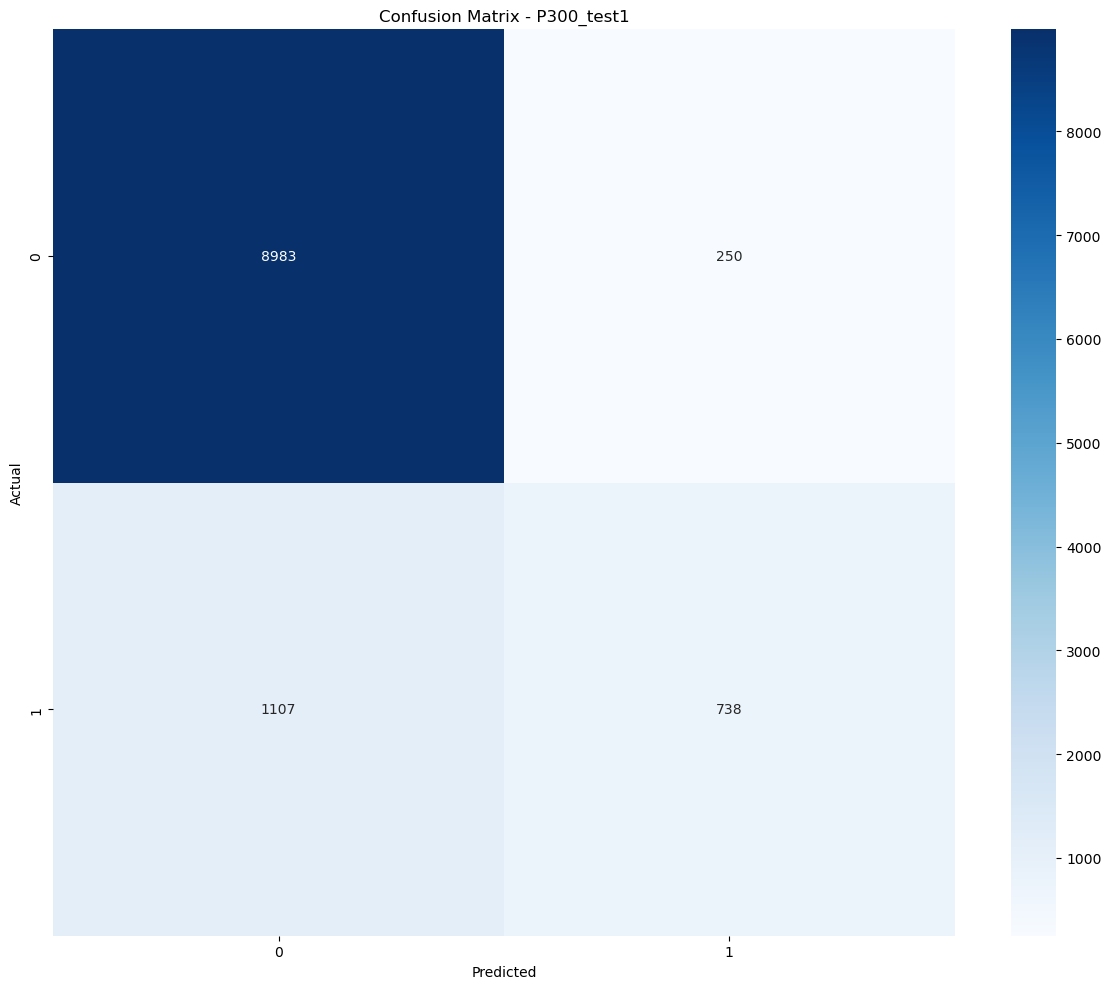


--- Test2 (Unseen subjects) ---
Test Accuracy: 84.33%
F1 Score: 0.8160
Precision: 0.8152
Recall: 0.8433
AUC: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7920
           1       0.57      0.24      0.34      1584

    accuracy                           0.84      9504
   macro avg       0.72      0.60      0.63      9504
weighted avg       0.82      0.84      0.82      9504



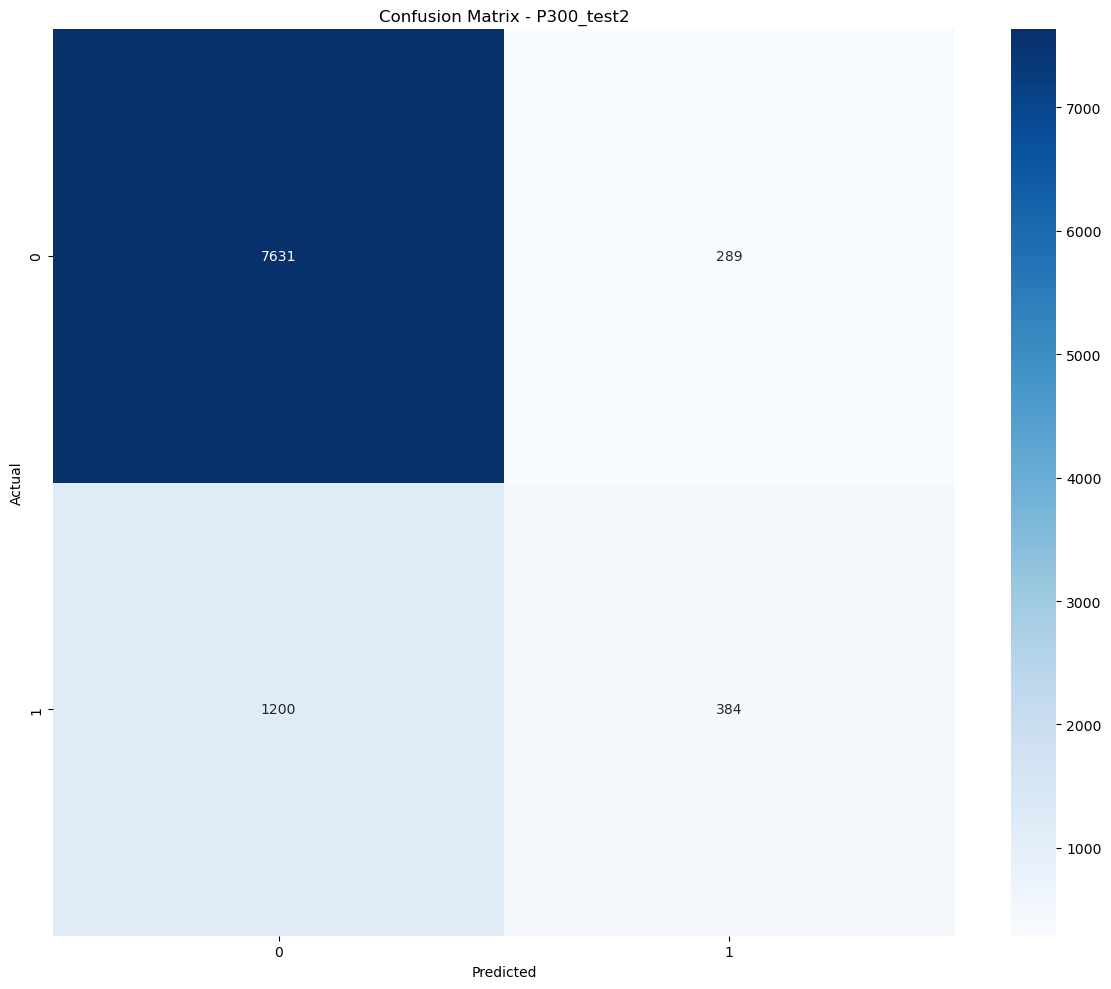


P300 completed!
Best validation accuracy: 88.40%
Test1 accuracy: 87.75%
Test2 accuracy: 84.33%

TASK: Imagined_speech
Configuration: {'num_classes': 11, 'channels': 62, 'timepoints': 4900, 'num_subjects': 14, 'num_seen': 8, 'data_dir': '/ocean/projects/cis250213p/shared/img_speech', 'label_dir': None}
Available subjects: ['MM05', 'MM08', 'MM09', 'MM10', 'MM11', 'MM12', 'MM14', 'MM15', 'MM16', 'MM18', 'MM19', 'MM20', 'MM21', 'P02']
Total subjects found: 14
[Imagined Speech Split] Seen:   ['MM05', 'MM11', 'MM20', 'MM09', 'MM15', 'MM12', 'MM08', 'MM10']
[Imagined Speech Split] Unseen: ['MM14', 'MM16', 'MM18', 'MM19', 'MM21', 'P02']
2D data: 62 channels, 4900 timepoints
Data shape: (62, 4900)
Number of classes: 11
Detected FC input dimension: 12840
Model created with 3,516,203 parameters

Training Imagined_speech model...
Training on device: cuda
Number of parameters: 3,516,203
Early stopping patience: 10
New best model saved! Val Acc: 2.53%
Epoch 1/50:
  Train Loss: 2.2995, Train Acc: 12

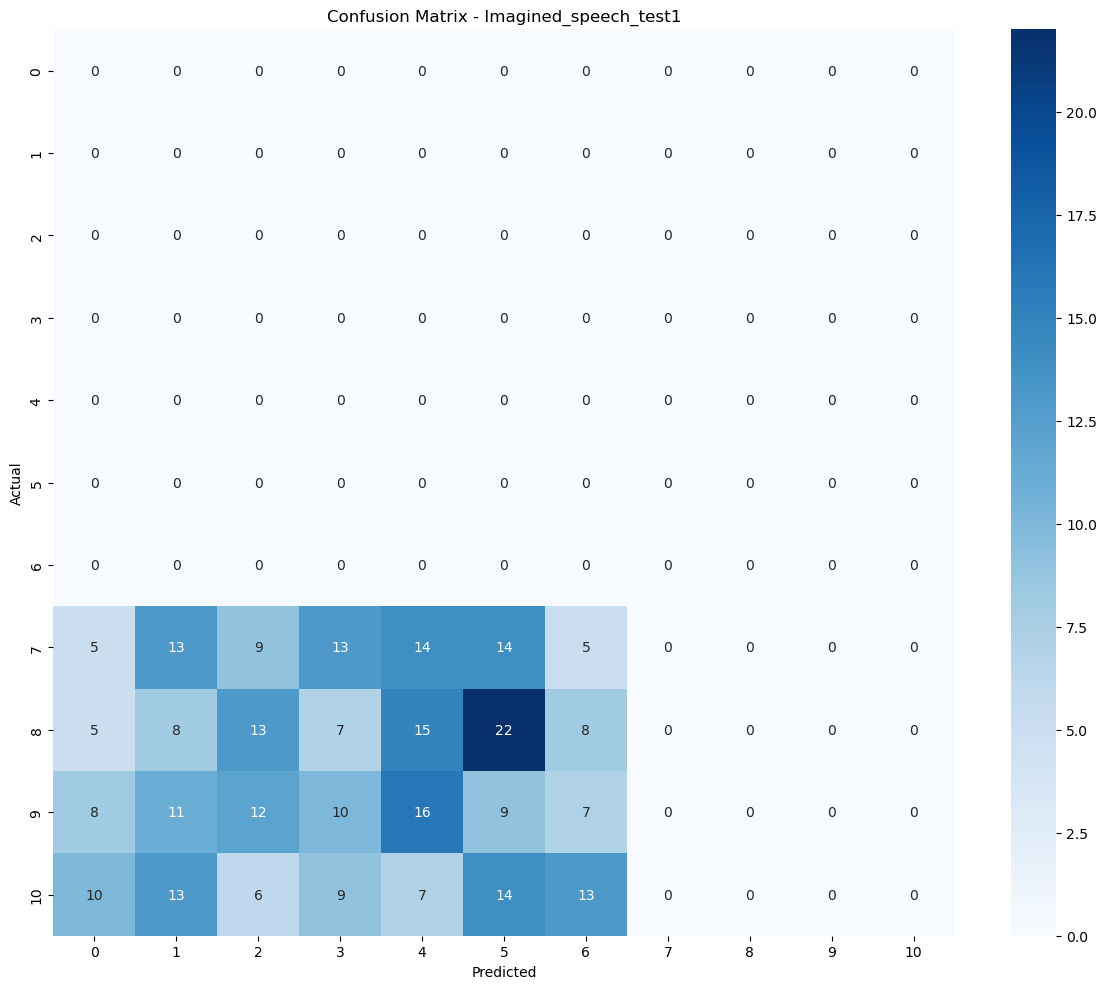


--- Test2 (Unseen subjects) ---
Test Accuracy: 9.94%
F1 Score: 0.0761
Precision: 0.0663
Recall: 0.0994
AUC: 0.4970

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.11      0.13        75
           1       0.10      0.21      0.14        75
           2       0.12      0.19      0.15        75
           3       0.11      0.24      0.15        75
           4       0.08      0.09      0.08        75
           5       0.08      0.16      0.11        75
           6       0.07      0.09      0.08        75
           7       0.00      0.00      0.00        75
           8       0.00      0.00      0.00        75
           9       0.00      0.00      0.00        75
          10       0.00      0.00      0.00        75

    accuracy                           0.10       825
   macro avg       0.07      0.10      0.08       825
weighted avg       0.07      0.10      0.08       825



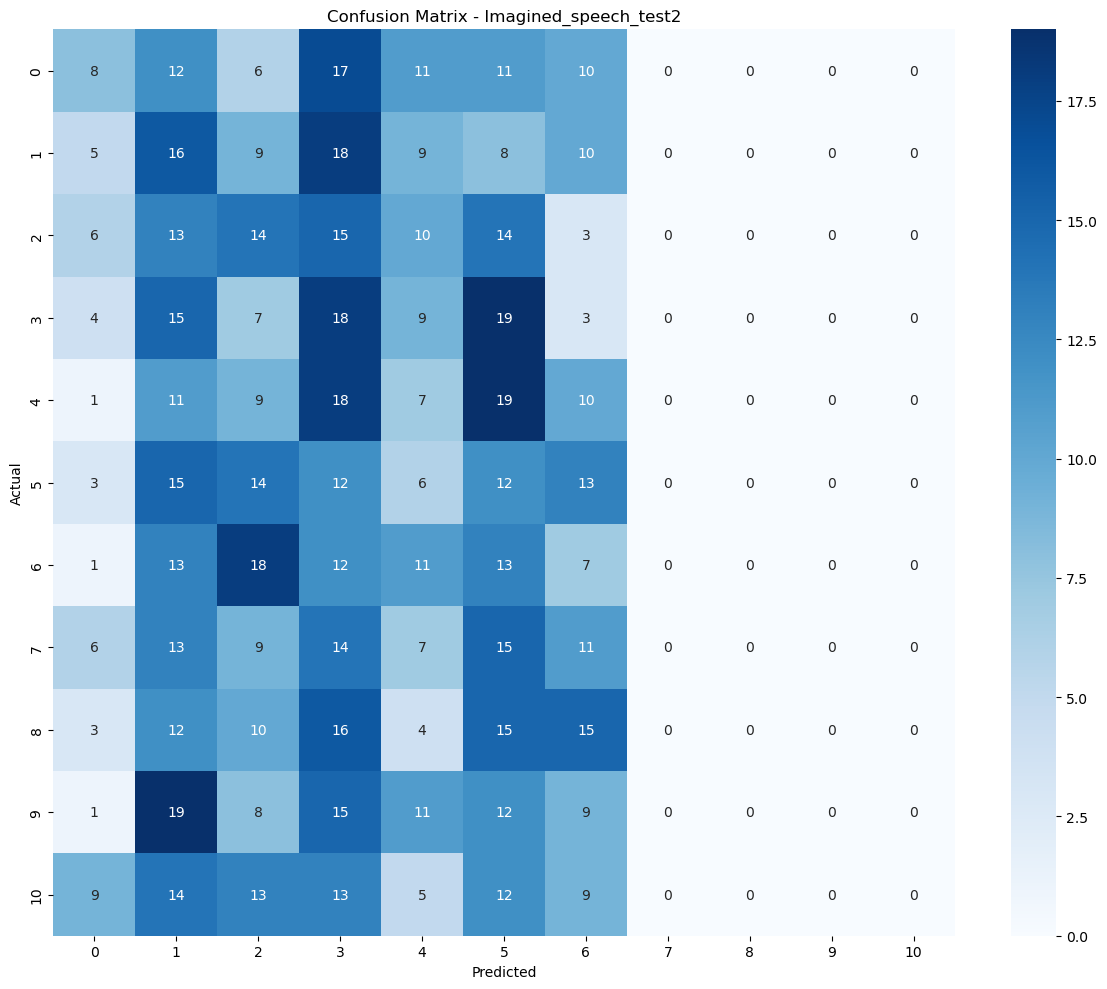


Imagined_speech completed!
Best validation accuracy: 7.07%
Test1 accuracy: 0.00%
Test2 accuracy: 9.94%

SUMMARY RESULTS

MI:
  Best Val Acc: 56.25%
  Test1 Acc: 49.40%
  Test2 Acc: 43.23%
  Test1 F1: 0.4909
  Test2 F1: 0.4298

P300:
  Best Val Acc: 88.40%
  Test1 Acc: 87.75%
  Test2 Acc: 84.33%
  Test1 F1: 0.8617
  Test2 F1: 0.8160

Imagined_speech:
  Best Val Acc: 7.07%
  Test1 Acc: 0.00%
  Test2 Acc: 9.94%
  Test1 F1: 0.0000
  Test2 F1: 0.0761

MULTI-TASK EVALUATION COMPLETED!


In [11]:
# Main execution loop for multi-task evaluation
print("=" * 80)
print("MULTI-TASK BASELINE EVALUATION WITH EEG TRANSFORMER")
print("=" * 80)

# TASKS = ['Imagined_speech']
TASKS = ['MI', 'P300', 'Imagined_speech']

all_task_results = {}

for task in TASKS:
    print(f"\n{'='*60}")
    print(f"TASK: {task}")
    print(f"{'='*60}")
    
    config = TASK_CONFIGS[task]
    print(f"Configuration: {config}")
    
    # Load dataset based on task
    if task == "P300":
        datasets = P300_load_split_dataset(
            root_dir=config["data_dir"],
            num_seen=config["num_seen"],
            seed=43,
            label_dir=config["label_dir"]
        )
    elif task == "MI":
        datasets = MI_load_split_dataset(
            root_dir=config["data_dir"],
            num_seen=config["num_seen"],
            seed=43,
            label_dir=config["label_dir"]
        )
    elif task == "Imagined_speech":
        datasets = ImaginedSpeech_load_split_dataset(
            root_dir=config["data_dir"],
            num_seen=config["num_seen"],
            seed=43,
            label_dir=config["label_dir"]
        )
    
    # Check if datasets were loaded successfully
    if not datasets:
        print(f"Warning: No data loaded for {task}. Skipping...")
        continue
    
    # Create datasets (without STFT)
    train_dataset = EEGDataset(datasets['train'][0], datasets['train'][1], normalize=True)
    val_dataset = EEGDataset(datasets['val'][0], datasets['val'][1], normalize=True)
    test1_dataset = EEGDataset(datasets['test1'][0], datasets['test1'][1], normalize=True)
    test2_dataset = EEGDataset(datasets['test2'][0], datasets['test2'][1], normalize=True)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test1_loader = DataLoader(test1_dataset, batch_size=32, shuffle=False)
    test2_loader = DataLoader(test2_dataset, batch_size=32, shuffle=False)
    
    # Get data dimensions
    sample_data = datasets['train'][0][0]
    if len(sample_data.shape) == 2:  # (channels, time)
        n_channels = sample_data.shape[0]
        n_times = sample_data.shape[1]
        print(f"2D data: {n_channels} channels, {n_times} timepoints")
    elif len(sample_data.shape) == 3:  # (trials, channels, time)
        n_channels = sample_data.shape[1]
        n_times = sample_data.shape[2]
        print(f"3D data: {n_channels} channels, {n_times} timepoints")
    else:
        print(f"Unexpected data shape: {sample_data.shape}")
        continue
    
    print(f"Data shape: {sample_data.shape}")
    print(f"Number of classes: {config['num_classes']}")
    
    # Create EEGConformer model
    model = EEGConformer(
        n_chans=n_channels,
        n_times=n_times,
        n_outputs=config['num_classes']
    )

    # Adjust final layer if needed
    base = model
    shapes = {}
    def pre_fc_hook(m, inp):
        shapes['before_fc'] = inp[0].shape  # (B, ...)

    h = base.fc.register_forward_pre_hook(pre_fc_hook)

    probe_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base = base.to(probe_device)
    xb = next(iter(train_loader))[0].to(probe_device).float()

    base.eval()
    with torch.no_grad():
        try:
            _ = base(xb)
        except RuntimeError:
            pass
    h.remove()
    base.train()

    K = int(np.prod(shapes['before_fc'][1:]))
    print(f"Detected FC input dimension: {K}")

    old_fc_seq = base.fc.fc
    linears = [m for m in old_fc_seq if isinstance(m, nn.Linear)]
    h1 = linears[0].out_features if len(linears) > 0 else 256
    h2 = linears[1].out_features if len(linears) > 1 else 32

    new_fc = nn.Sequential(
        nn.Linear(K, h1),
        nn.ELU(),
        nn.Dropout(p=0.5),
        nn.Linear(h1, h2),
        nn.ELU(),
        nn.Dropout(p=0.3),
    )
    base.fc.fc = new_fc
    
    model = nn.DataParallel(model, device_ids=[0,1,2,3]).to(device)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Train model
    print(f"\nTraining {task} model...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model_enhanced(
        model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, task_name=task
    )
    
    # Evaluate on test sets
    print(f"\nEvaluating {task} model...")
    
    print("\n--- Test1 (Seen subjects, unseen sessions) ---")
    test1_results = evaluate_model_enhanced(model, test1_loader, task_name=f"{task}_test1")
    
    print("\n--- Test2 (Unseen subjects) ---")
    test2_results = evaluate_model_enhanced(model, test2_loader, task_name=f"{task}_test2")
    
    # Store results
    all_task_results[task] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test1_results': test1_results,
        'test2_results': test2_results,
        'best_val_acc': max(val_accuracies)
    }
    
    print(f"\n{task} completed!")
    print(f"Best validation accuracy: {max(val_accuracies):.2f}%")
    print(f"Test1 accuracy: {test1_results['accuracy']:.2f}%")
    print(f"Test2 accuracy: {test2_results['accuracy']:.2f}%")

# Summary results
print(f"\n{'='*80}")
print("SUMMARY RESULTS")
print(f"{'='*80}")

for task in TASKS:
    if task in all_task_results:
        results = all_task_results[task]
        print(f"\n{task}:")
        print(f"  Best Val Acc: {results['best_val_acc']:.2f}%")
        print(f"  Test1 Acc: {results['test1_results']['accuracy']:.2f}%")
        print(f"  Test2 Acc: {results['test2_results']['accuracy']:.2f}%")
        print(f"  Test1 F1: {results['test1_results']['f1']:.4f}")
        print(f"  Test2 F1: {results['test2_results']['f1']:.4f}")

print(f"\n{'='*80}")
print("MULTI-TASK EVALUATION COMPLETED!")
print(f"{'='*80}")
